In [2]:
import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Normalize
from torch import nn
import torch.optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


In [84]:
def normalize(x, eps=1e-8):
    eta, u, v = x[:,0,:,:], x[:,1,:,:], x[:,2,:,:]
    u_max, u_min = u.max(), u.min()
    v_max, v_min = v.max(), v.min()
    eta_max, eta_min = eta.max(), eta.min()

    def safe_normalize(var, vmin, vmax):
        if (vmax - vmin).abs() < eps:
            return torch.zeros_like(var)  # or torch.ones_like(var), your choice
        return 2 * (var - vmin) / (vmax - vmin) - 1

    eta_norm = safe_normalize(eta, eta_min, eta_max)
    u_norm = safe_normalize(u, u_min, u_max)
    v_norm = safe_normalize(v, v_min, v_max)

    x_norm = torch.cat([
        eta_norm.unsqueeze(1), 
        u_norm.unsqueeze(1), 
        v_norm.unsqueeze(1)
    ], dim=1)

    return x_norm, [u_max, u_min, v_max, v_min, eta_max, eta_min]


def denormalize(x_norm, max_min_vals, eps=1e-8):
    eta_norm, u_norm, v_norm = x_norm[:,0,:,:], x_norm[:,1,:,:], x_norm[:,2,:,:]
    u_max, u_min, v_max, v_min, eta_max, eta_min  = max_min_vals

    # Prevent extremely small denominators
    du = u_max - u_min
    dv = v_max - v_min
    deta = eta_max - eta_min

    if du.abs() < eps: du = eps
    if dv.abs() < eps: dv = eps
    if deta.abs() < eps: deta = eps

    u = ((u_norm + 1) / 2) * du + u_min
    v = ((v_norm + 1) / 2) * dv + v_min
    eta = ((eta_norm + 1) / 2) * deta + eta_min

    u = u.unsqueeze(1)
    v = v.unsqueeze(1)
    eta = eta.unsqueeze(1)
    x = torch.cat((eta, u, v), dim=1)
    
    return x
    
class dataset(Dataset): 
    def __init__(self, data, ic, length):
        self.data = data
        self.len = length
        self.ic = ic
    def __len__(self):
        return self.len
    def __getitem__(self, idx):
        dataPoint = self.data[idx, :, :, :]
        initial_condition = self.ic[idx, :, :, :]
        return dataPoint, initial_condition

def training_loop(dataLoader, model, device, optimizer, loss_fn, epochs, path, batchSize, Mse_loss_fn):
    for epoch in range(epochs):
        for batch in dataLoader:
            data, ic = batch
            data = data.to(device)
            ic = ic.to(device)
            optimizer.zero_grad()
            pred = model(data).view(batchSize, 3, 64, 64)
            loss = loss_fn(pred, ic, Mse_loss_fn)
            loss.backward()
            optimizer.step()
        print(f'epoch {epoch} : loss {loss.item()}') 
    torch.save(model.state_dict(), path)

def loss_function(output, target, Mse_loss_fn):
    # define a custom loss function for the model to train. Both output and pred have shapes [batchSize, 3, 64, 64].
    # goal is to calculate channel wise-loss, and encourage sparsity in u and v 
    # MSELoss_fn must be a object of class nn.MSELoss() to calculate loss in eta

    u_target, u_output = target[:, 1, :, :] , output[:, 1, :, :]
    v_target, v_output = target[:, 2, :, :] , output[:, 2, :, :]
    eta_target, eta_output = target[:, 0, :, :] , output[:, 0, :, :]

    eta_error = Mse_loss_fn(eta_target, eta_output)
    # u_error = lr * L1loss_fn(u_target, u_output) 
    # v_error = lr * L1loss_fn(v_target, v_output)
    u_error = Mse_loss_fn(u_target, u_output) 
    v_error = Mse_loss_fn(v_target, v_output)

    total_err = torch.stack([eta_error, u_error, v_error]).mean()

    return total_err

def plot_figs(idx, X1, X2):  
    # function used to plot actual vs predicted initial conditions for 1 datapoint
    x = np.linspace(0, 1, 64)
    y = np.linspace(0, 1, 64)
    X, Y = np.meshgrid(x, y)

    eta1 = X1[idx, 0, :, :].cpu()
    u1 = X1[idx, 1, :, :].cpu()
    v1 = X1[idx, 2, :, :].cpu()
    eta2 = X2[idx, 0, :, :].cpu()
    u2 = X2[idx, 1, :, :].cpu()
    v2 = X2[idx, 2, :, :].cpu()

    fig, axes = plt.subplots(2, 3, figsize=(18, 8), subplot_kw={'projection': '3d'})

    titles = [
        "Actual η", "Actual u", "Actual v",
        "Nonlinear Predicted η", "Nonlinear Predicted u", "Nonlinear Predicted v"
    ]
    Zs = [eta1, u1, v1, eta2, u2, v2]
    cmaps = ['viridis', 'viridis', 'plasma', 'viridis', 'viridis', 'plasma']

    for i, ax in enumerate(axes.flat):
        ax.plot_surface(X, Y, Zs[i], cmap=cmaps[i])
        if i==1 or i==2 or i==4 or i==5:
            ax.set_zlim(-1e-3, 1e-3)
        else:
            min_z, max_z = Zs[0].min(), Zs[0].max()
            ax.set_zlim(min_z, max_z)
        ax.set_title(titles[i], fontsize=18, pad=10)
        ax.set_xlabel('x', fontsize=12, labelpad=5)
        ax.set_ylabel('y', fontsize=12, labelpad=5)
        ax.tick_params(axis='both', labelsize=10)

    # Try to reduce whitespace (tight_layout often has limited effect on 3D)
    #plt.tight_layout(pad=2.0)
    plt.subplots_adjust(hspace=0.3, wspace=0.1)  # manual tuning

    plt.show()

In [39]:
class fullyConnectedInverse(nn.Module):
    def __init__(self, bottleneck):
        super().__init__()
        self.bottleneck = bottleneck
        self.encoder = nn.Sequential(
            nn.Flatten(),                        # (3, 64, 64) → (12288)
            nn.Linear(3*64*64, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 250)                 # Output latent vector
        )
        self.decoder = nn.Sequential(
            nn.Linear(250, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(2048, 3*64*64),
            nn.Tanh(),                          
        )

    def forward(self, x):
        x = x.view(-1, 3*64*64)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        x_hat = x_hat.view(-1, 3, 64, 64)

        return x_hat
    

In [18]:
# if createSWEdata.py is being run for the first time, run the first block of code to 
# load data into single files
# if single files have already been created, then run only the second block of data to load the files

# --- creating single files of data ---
ic_names = ["Gaussian Bump", "2 Gaussian Bumps", "Sinusoidal Wave Pattern", "Flat Conditions"]
num_dataPoints = 4 * 2500
ic_set = torch.zeros(size=(num_dataPoints, 3, 64, 64)) # rows are eta,u,v for each datapoint. Columns are per datapoint. 
data_set = torch.zeros(size=(num_dataPoints, 3, 64, 64)) # each datapoint has shape 3x64x64 (3 channels over 64x64 grid)
case = 64
batches = 2500

i=1
for ic_name in ic_names:
    x = torch.load(f'data/train_x1_{ic_name}_allBatch_Close.pt')[:2500, :, :, :]
    print(x.shape)
    ic = torch.load(f'data/train_ic_{ic_name}_allBatch.pt')[:2500, :, :, :]
    print(x.shape)
    data_set[batches*(i-1): batches*i] = x
    ic_set[batches*(i-1): batches*i] = ic
    i = i+1
# save full datasets 
torch.save(data_set, f"data/training_data_10000.pt")
torch.save(ic_set, f"data/ic_training_data_10000.pt")

torch.Size([2500, 3, 64, 64])
torch.Size([2500, 3, 64, 64])
torch.Size([2500, 3, 64, 64])
torch.Size([2500, 3, 64, 64])
torch.Size([2500, 3, 64, 64])
torch.Size([2500, 3, 64, 64])
torch.Size([2500, 3, 64, 64])
torch.Size([2500, 3, 64, 64])


In [68]:
#
# --- loading the data into variables ---
#

data_set = torch.load('data/training_data_10000.pt').clone()
ic_set = torch.load('data/ic_training_data_10000.pt').clone()

In [78]:
size = 10000
batchSize = 80
# --- normalization of each channel using min and max, with output range [-1,1]
dataset_normalized, min_max_vals = normalize(data_set)
ic_normalized, min_max_vals_ic = normalize(ic_set)

# add noise to observations
noise = 0.1
dataset_normalized += 0.1 * torch.randn(dataset_normalized.shape)

# initialize objects for pyTorch flow
DataSet = dataset(dataset_normalized, ic_normalized, size)
dataLoader = DataLoader(DataSet, shuffle=True, batch_size=batchSize, num_workers=0)
loss_fn = nn.MSELoss(reduction='none')

model_inverse = fullyConnectedInverse(1000)
model_inverse = model_inverse.to(device)

optimizer_inverse = torch.optim.Adam(model_inverse.parameters(), lr=1e-4)

# if model has already been stored, one can directly load model using block of code below and skip training
model_saved = True

if model_saved:
    model_path = "inv_model_fc.pth"
    state_dict= torch.load(model_path, map_location=device)
    model_inverse.load_state_dict(state_dict) 

In [36]:
# --- training loop ---

epochs = 100
model_path = 'inv_model_fc.pth' # define path to store model states after training
Mse_loss_fn = nn.MSELoss()

training_loop(dataLoader, model_inverse, device, optimizer_inverse, loss_function, epochs, path, batchSize, Mse_loss_fn)

epoch 0 : loss 0.020885339006781578
epoch 1 : loss 0.025238629430532455
epoch 2 : loss 0.028085967525839806
epoch 3 : loss 0.020900767296552658
epoch 4 : loss 0.027628395706415176
epoch 5 : loss 0.023890066891908646
epoch 6 : loss 0.03204884007573128
epoch 7 : loss 0.02908516302704811
epoch 8 : loss 0.019408587366342545
epoch 9 : loss 0.019136393442749977
epoch 10 : loss 0.021486695855855942
epoch 11 : loss 0.01608097366988659
epoch 12 : loss 0.024945378303527832
epoch 13 : loss 0.01713237166404724
epoch 14 : loss 0.016612861305475235
epoch 15 : loss 0.02243097685277462
epoch 16 : loss 0.020866435021162033
epoch 17 : loss 0.025412529706954956
epoch 18 : loss 0.019101819023489952
epoch 19 : loss 0.01407371461391449
epoch 20 : loss 0.016960736364126205
epoch 21 : loss 0.01591813750565052
epoch 22 : loss 0.01236194372177124
epoch 23 : loss 0.019550930708646774
epoch 24 : loss 0.021390702575445175
epoch 25 : loss 0.018796773627400398
epoch 26 : loss 0.017775584012269974
epoch 27 : loss 0.0

In [79]:
# --- compute reconstructions and errors ---
size = 10000
batchSize = 80
test_dataLoader = DataLoader(DataSet, shuffle=False, batch_size=batchSize)
model = model_inverse
model.eval()
ics = torch.zeros(size=(size, 3, 64, 64)) # store initial conditions in new variable, in same order as reconstrctions
reconstructions = torch.zeros(size=(size, 3, 64, 64))
data_stored = torch.zeros(size=(size, 3, 64, 64)) # store data (input conditions) in a new variable, in same order as reconstructions
i=0
with torch.no_grad():
    for batch in test_dataLoader:
        data, ic = batch
        data, ic = data.to(device), ic.to(device)
        pred = model(data).view(batchSize, 3, 64, 64)
        reconstructions[i:batchSize+i, :, :, :] = pred
        ics[i:batchSize+i, :, :, :] = ic
        data_stored[i:batchSize+i, :, :, :] = data
        i += batchSize

reconstruction_denormalized = denormalize(reconstructions, min_max_vals_ic)
ics_denormalized = denormalize(ics, min_max_vals_ic)
data_denormalized = denormalize(data_stored, min_max_vals)

total_err = torch.norm(reconstruction_denormalized - ics_denormalized) / torch.norm(ics_denormalized)

eta_err = torch.norm(reconstruction_denormalized[:,0,:,:] - ics_denormalized[:,0,:,:] ) / torch.norm( ics_denormalized[:,0,:,:])
u_err = torch.abs(reconstruction_denormalized[:,1,:,:]  - ics_denormalized[:,1,:,:] ).mean()
v_err = torch.abs(reconstruction_denormalized[:,2,:,:]  - ics_denormalized[:,2,:,:]).mean()

print(f'Total Error : {total_err}')
print(f'eta error : {eta_err} , u error : {u_err} , v error : {v_err}')

Total Error : 0.2258317917585373
eta error : 0.22623400390148163 , u error : 7.53588174120523e-05 , v error : 7.53481945139356e-05


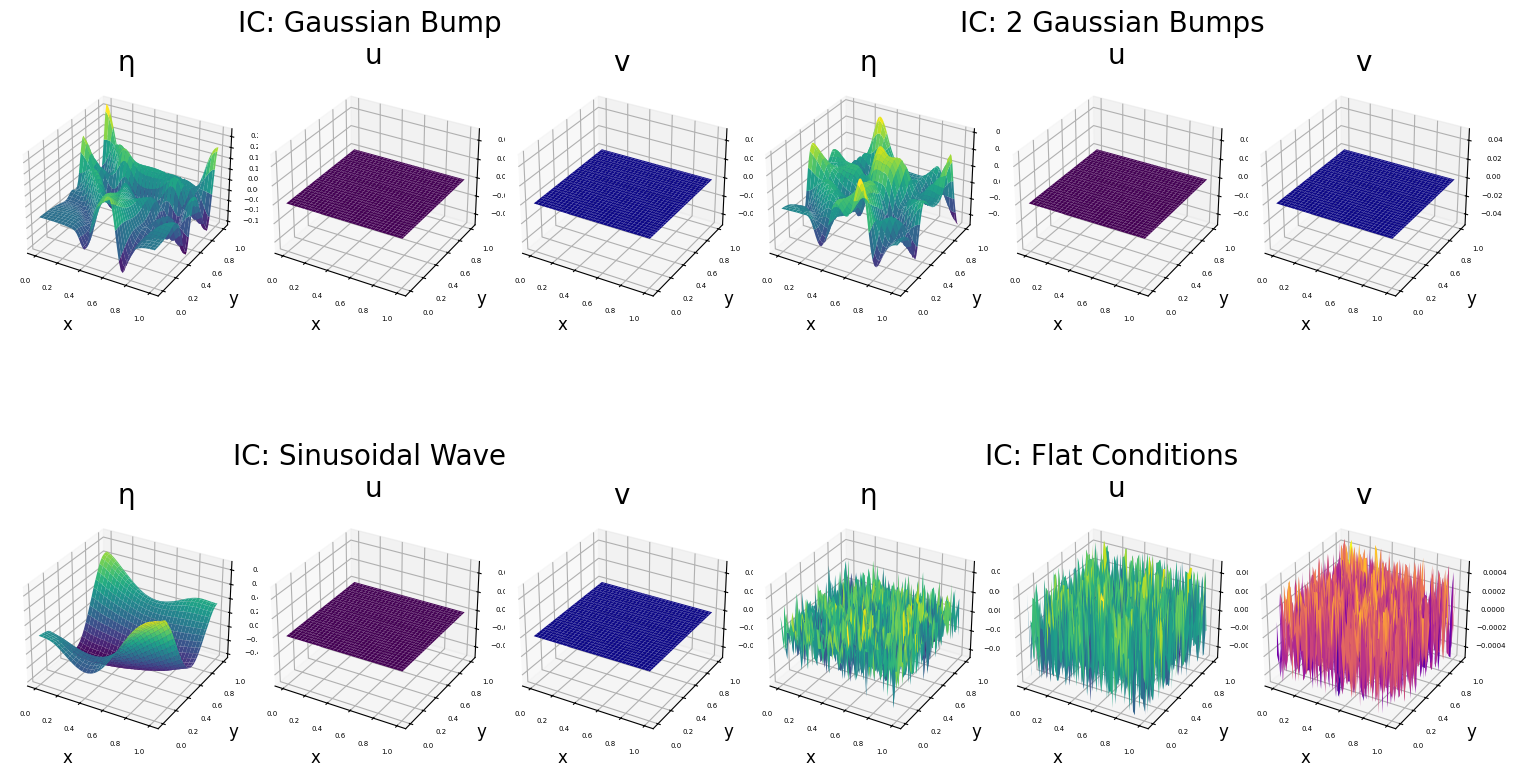

In [47]:
# 
# --- plot initial conditions only, for 4 different data points ---
#

fig, axes = plt.subplots(2, 6, figsize=(15, 10), subplot_kw={'projection': '3d'})
x = np.linspace(0, 1, 64)
y = np.linspace(0, 1, 64)
X, Y = np.meshgrid(x, y)

indices = [0,3000,6000,9000]
gaussian = ics_denormalized[indices[0], :, :, :]
two_gaussian = ics_denormalized[indices[1], :, :, :]
sinusoidal = ics_denormalized[indices[2], :, :, :]
flat = ics_denormalized[indices[3], :, :, :]

Zs = [gaussian[0,:,:], gaussian[1,:,:], gaussian[2,:,:], two_gaussian[0,:,:], two_gaussian[1,:,:], two_gaussian[2,:,:],
    sinusoidal[0,:,:], sinusoidal[1,:,:], sinusoidal[2,:,:], flat[0,:,:], flat[1,:,:], flat[2,:,:] ]
titles = [ "η", "u", "v",  "η", "u", "v",  "η", "u", "v",  "η", "u", "v" ]
ics = ["IC: Gaussian Bump \nu","IC: 2 Gaussian Bumps \nu", "IC: Sinusoidal Wave \nu","IC: Flat Conditions \nu"]
cmaps = ['viridis', 'viridis', 'plasma', 'viridis', 'viridis', 'plasma',
        'viridis', 'viridis', 'plasma', 'viridis', 'viridis', 'plasma']

k=0
for i, ax in enumerate(axes.flat):
    ax.plot_surface(X, Y, Zs[i], cmap=cmaps[i])
    ax.set_title(titles[i], fontsize=20, pad=5)
    if ((i-1)%3==0):
        ax.set_title(ics[k], fontsize=20, pad=10)
        k += 1
    ax.set_xlabel('x', fontsize=12, labelpad=5)
    ax.set_ylabel('y', fontsize=12, labelpad=5)
    ax.tick_params(axis='both', labelsize=5)
    ax.axis('tight')
    
plt.subplots_adjust(hspace=0.1, wspace=0.1)  # manual tuning

plt.tight_layout()  # Adjusts spacing to prevent overlap
plt.show()

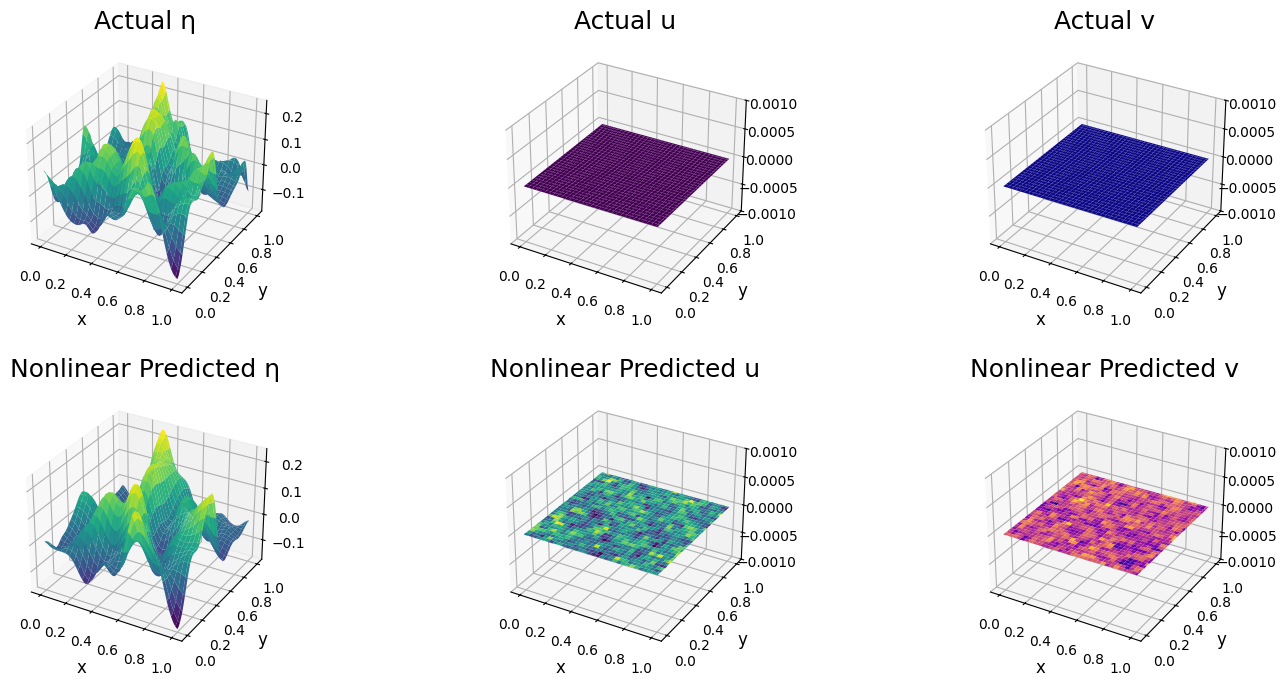

In [80]:
# 
# --- plot predictions vs actual initial conditions for 1 datapoint ---
#
idx = 4000
original = ics_denormalized
predicted = reconstruction_denormalized

plot_figs(idx, original, predicted)


In [9]:
#### errors in individual variables, for the plotted instance
idx = 4000
total_err = torch.norm(reconstruction_denormalized[idx,:,:,:] - ics_denormalized[idx,:,:,:]) / torch.norm(ics_denormalized[idx,:,:,:])
eta_err = torch.norm(reconstruction_denormalized[idx,0,:,:] - ics_denormalized[idx,0,:,:] ) / torch.norm(ics_denormalized[idx,0,:,:])
u_err = torch.abs(reconstruction_denormalized[idx,1,:,:]  - ics_denormalized[idx,1,:,:] ).mean()
v_err = torch.abs(reconstruction_denormalized[idx,2,:,:]  - ics_denormalized[idx,2,:,:]).mean()

print(f'Total Error : {total_err}')
print(f'eta error : {eta_err} , u error : {u_err} , v error : {v_err}')

Total Error : 0.33370715379714966
eta error : 0.33370715379714966 , u error : 2.4570613277319353e-06 , v error : 2.4928531274781562e-06


Total Error : 0.26231494545936584
eta error : 0.2623646855354309 , u error : 6.397692050086334e-05 , v error : 6.401735299732536e-05


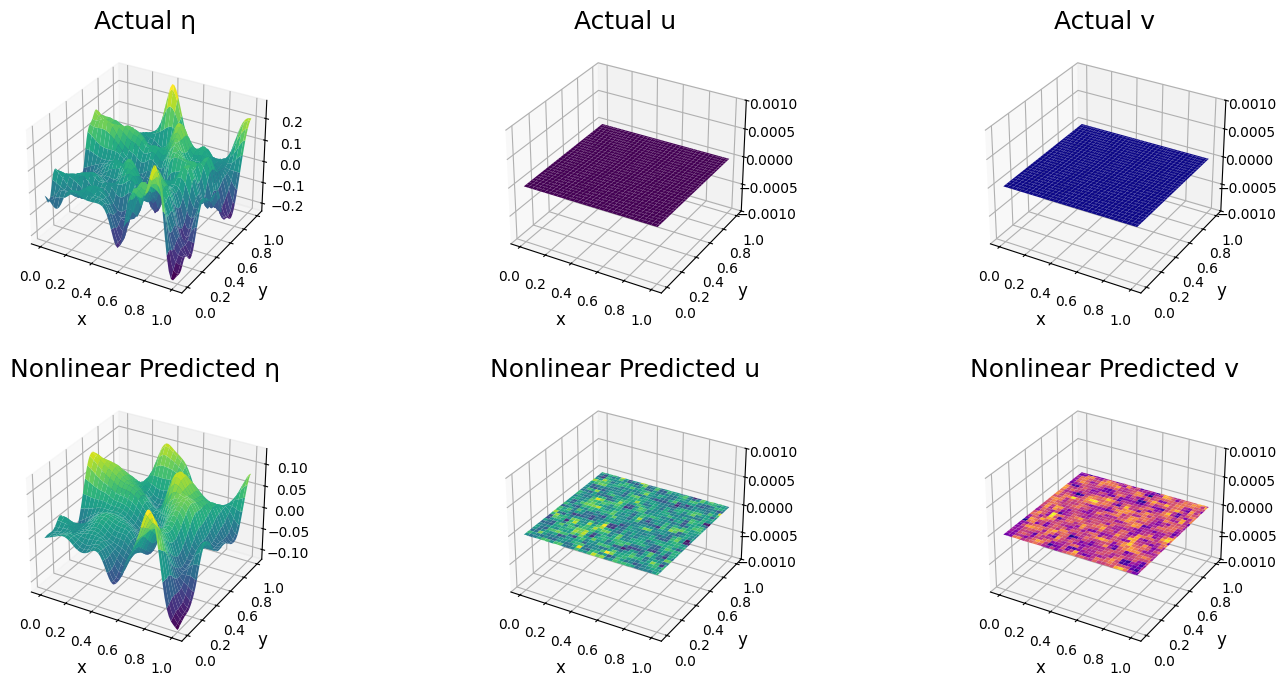

In [81]:
# testing error -> in distribution dataset
test_set = torch.load('test_data/testing_data_2000.pt').clone()
test_ic_set = torch.load('test_data/ic_testing_data_2000.pt').clone()

# to follow the same flow as nonlinear case, normalize and add noise, then denormalize
test_dataset_normalized, test_min_max_vals = normalize(test_set)
test_ic_normalized, test_ic_min_max_vals = normalize(test_ic_set)
test_dataset_normalized += 0.1 * torch.randn(test_dataset_normalized.shape)
test_dataset_denormalized = denormalize(test_dataset_normalized, test_min_max_vals)

size = 2000
batchSize=50
test_dataset = dataset(test_dataset_normalized, test_ic_normalized, size)

test_dataLoader = DataLoader(test_dataset, shuffle=False, batch_size=batchSize)
model = model_inverse
model.eval()
ics = torch.zeros(size=(size, 3, 64, 64)) # store initial conditions in new variable, in same order as reconstrctions
reconstructions = torch.zeros(size=(size, 3, 64, 64))
data_stored = torch.zeros(size=(size, 3, 64, 64)) # store data (input conditions) in a new variable, in same order as reconstructions
i=0
with torch.no_grad():
    for batch in test_dataLoader:
        data, ic = batch
        data, ic = data.to(device), ic.to(device)
        pred = model(data).view(batchSize, 3, 64, 64)
        reconstructions[i:batchSize+i, :, :, :] = pred
        ics[i:batchSize+i, :, :, :] = ic
        data_stored[i:batchSize+i, :, :, :] = data
        i += batchSize

reconstruction_denormalized = denormalize(reconstructions, min_max_vals_ic)
ics_denormalized = denormalize(ics, test_ic_min_max_vals)
data_denormalized = denormalize(data_stored, min_max_vals)

total_err = torch.norm(reconstruction_denormalized - ics_denormalized) / torch.norm(ics_denormalized)

eta_err = torch.norm(reconstruction_denormalized[:,0,:,:] - ics_denormalized[:,0,:,:] ) / torch.norm( ics_denormalized[:,0,:,:])
u_err = torch.abs(reconstruction_denormalized[:,1,:,:]  - ics_denormalized[:,1,:,:] ).mean()
v_err = torch.abs(reconstruction_denormalized[:,2,:,:]  - ics_denormalized[:,2,:,:]).mean()

print(f'Total Error : {total_err}')
print(f'eta error : {eta_err} , u error : {u_err} , v error : {v_err}')

plot_figs(500, ics_denormalized, reconstruction_denormalized)

# print(reconstruction_denormalized)


Total Error : 0.8721384839942721
eta error : 0.8721638433178025 , u error : 0.0005024829384403335 , v error : 0.0005019392053919721


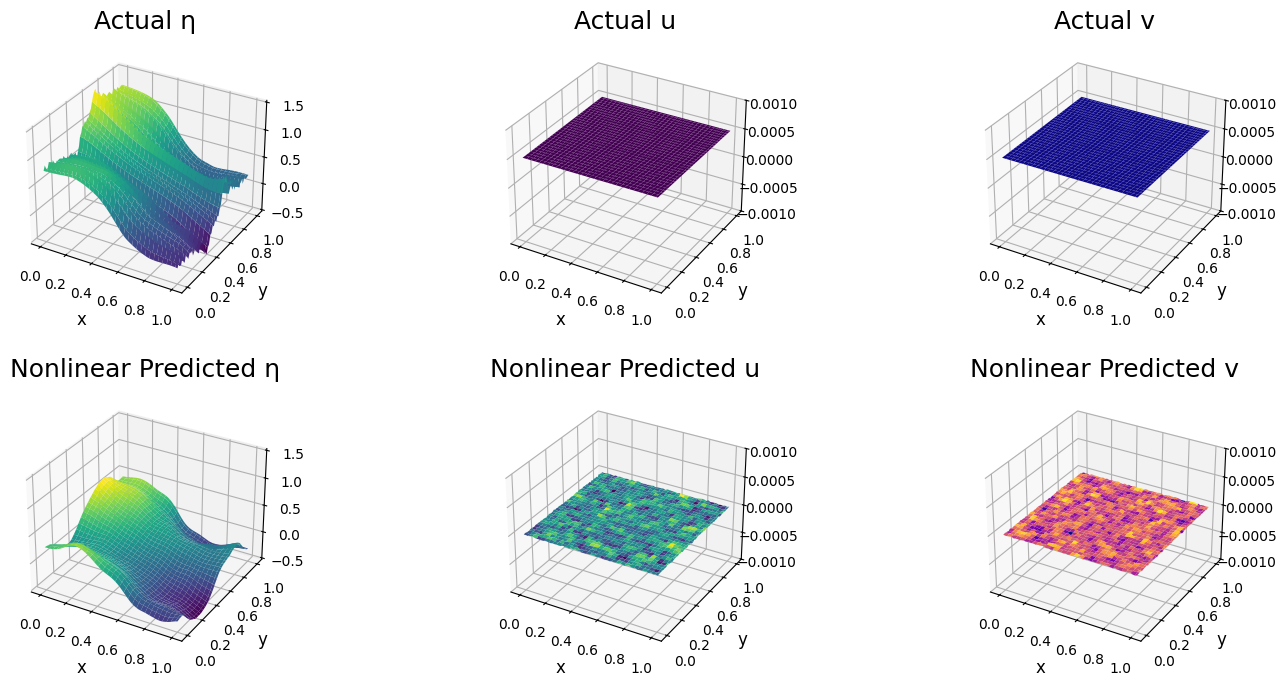

In [85]:
# testing error -> out of distribution dataset
test_set = torch.load('test_data/OOD_testing_data_2000.pt').clone()
test_ic_set = torch.load('test_data/OOD_ic_testing_data_2000.pt').clone()

# to follow the same flow as nonlinear case, normalize and add noise, then denormalize
test_dataset_normalized, test_min_max_vals = normalize(test_set)
test_ic_normalized, test_ic_min_max_vals = normalize(test_ic_set)
test_dataset_normalized += 0.1 * torch.randn(test_dataset_normalized.shape)
test_dataset_denormalized = denormalize(test_dataset_normalized, test_min_max_vals)

size = 1000
batchSize=50
test_dataset = dataset(test_dataset_normalized, test_ic_normalized, size)

test_dataLoader = DataLoader(test_dataset, shuffle=False, batch_size=batchSize)
model = model_inverse
model.eval()
ics = torch.zeros(size=(size, 3, 64, 64)) # store initial conditions in new variable, in same order as reconstrctions
reconstructions = torch.zeros(size=(size, 3, 64, 64))
data_stored = torch.zeros(size=(size, 3, 64, 64)) # store data (input conditions) in a new variable, in same order as reconstructions
i=0
with torch.no_grad():
    for batch in test_dataLoader:
        data, ic = batch
        data, ic = data.to(device), ic.to(device)
        pred = model(data).view(batchSize, 3, 64, 64)
        reconstructions[i:batchSize+i, :, :, :] = pred
        ics[i:batchSize+i, :, :, :] = ic
        data_stored[i:batchSize+i, :, :, :] = data
        i += batchSize

reconstruction_denormalized = denormalize(reconstructions.double(), min_max_vals_ic)
ics_denormalized = denormalize(ics, test_ic_min_max_vals, eps=1e-3)
data_denormalized = denormalize(data_stored, min_max_vals)

total_err = torch.norm(reconstruction_denormalized - ics_denormalized) / torch.norm(ics_denormalized)

eta_err = torch.norm(reconstruction_denormalized[:,0,:,:] - ics_denormalized[:,0,:,:] ) / torch.norm( ics_denormalized[:,0,:,:])
u_err = torch.abs(reconstruction_denormalized[:,1,:,:]  - ics_denormalized[:,1,:,:] ).mean()
v_err = torch.abs(reconstruction_denormalized[:,2,:,:]  - ics_denormalized[:,2,:,:]).mean()

print(f'Total Error : {total_err}')
print(f'eta error : {eta_err} , u error : {u_err} , v error : {v_err}')

idx = 900
plot_figs(idx, ics_denormalized, reconstruction_denormalized)


